<H2>Outlines:</H2>
<ul> 
<li><B>Dataset=</B> Temperature measurement in my flat </li>
<li><B>Goal=</B> Explore the data to understand how much the temperature can be predicted
</ul>

<H2>Roadmap</H2>
<ol>
<li><A HREF="#dataPreparation">Data preparation</A>
<li><A HREF="#strategy">Strategy for the data analysis</A>
<li><A HREF="#dayByDayModel">Day by day temperature variations modeling</A>
<li><A HREF="#dalyVariations">Hourly variations modeling</A>
<li><A HREF="#fullModel">Temperature prediction full modeling</A>
<li><A HREF="#summary">Summary and conclusion</A>
</ol>

In [2]:
#Load everything 
import re
import itertools 

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from statsmodels.tsa.stattools import acf, pacf #to check the autocorrelations
from sklearn import datasets, linear_model # for the linear regression 
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.tsa.stattools import adfuller #for Dickey-Fuller test 
from statsmodels.tsa.arima_model import ARIMA # ARIMA TS modeling

import statsmodels.api as sm #for SARIMAX (for seasonal ARIMA)


import warnings
warnings.filterwarnings('ignore') #ignore the warnings: to uncomment only at the end !!!

<H2>Load and clean the data</H2><A id="dataPreparation">

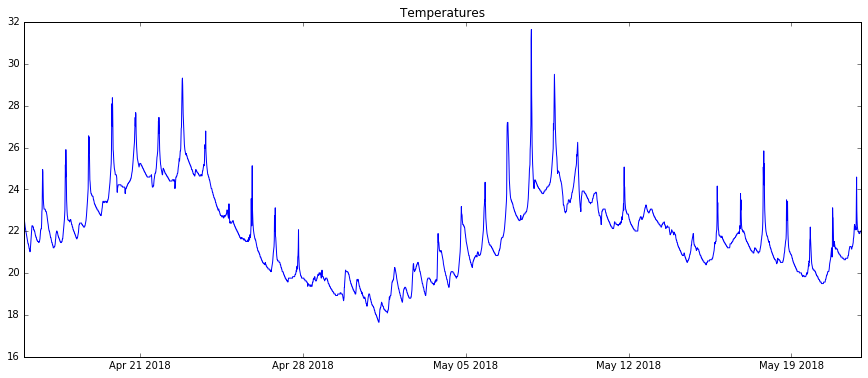

In [3]:
#read the CSV and parse the time-stamps
dateparse = lambda dates: pd.datetime.strptime(dates[:-6], '%Y-%m-%dT%H:%M:%S')
data = pd.read_csv('myHomeTemp.csv', parse_dates=['local'], index_col='local',date_parser=dateparse)
#create the time serie 
ts = data['celsius'] 
#select a time range with sencer at the same position
tsSelected=ts['2018-04-16':'2018-05-22 00:00']
#draw
plt.title('Temperatures')
plt.plot(tsSelected)

In [4]:
#clean the temperatures time series to have 1 measurement per hour 
theValues=[]
theIndex=[]
isFirst=True
currentTime=0
currentTimeStamp=tsSelected.index[0]
valuesToAverage=[]
for (anIndex, aValue) in zip(tsSelected.index,tsSelected):
    theStamp=pd.datetime.strptime(str(anIndex), '%Y-%m-%d %H:%M:%S')
    time=int(str(theStamp)[-8:-6])
    if time!=currentTime:
        #save the entry 
        theIndex.append(pd.datetime.strptime(str(currentTimeStamp)[:-5]+'00:00', '%Y-%m-%d %H:%M:%S'))
        theValues.append(np.mean(valuesToAverage))
        #now reset
        valuesToAverage=[]
        currentTime=time
        currentTimeStamp=theStamp
    valuesToAverage.append(aValue)

tsCleaned=pd.Series(theValues, theIndex)

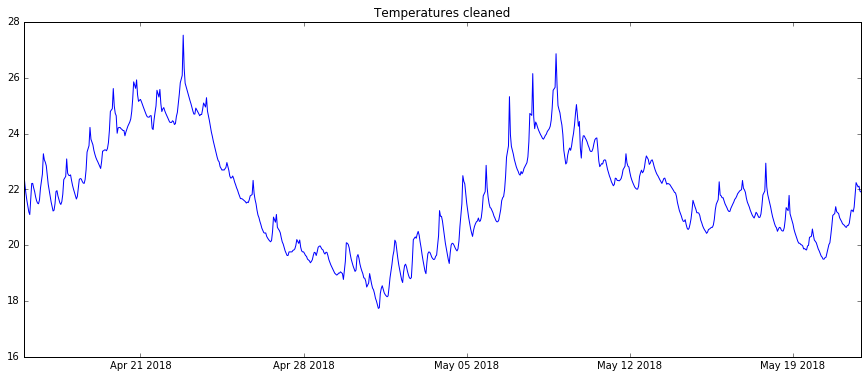

In [5]:
#between 18 and 19 hours, the sun reach directly the sensor preventing it to measure the air temperature: 
#then the 18h and 19h measurements are extrapolated from 17h and 20h 
tempCleanedFromPeak=[]
theIte=-1
for (aValue, aTimeStamp) in zip(tsCleaned,tsCleaned.index):
    theIte+=1
    time=int(str(aTimeStamp)[-8:-6])
    if time==18:
        tempCleanedFromPeak.append(tsCleaned[theIte-1]+1/4.*(tsCleaned[theIte+3]-tsCleaned[theIte-1]))
        continue
    elif time==19:
        tempCleanedFromPeak.append(tsCleaned[theIte-2]+2./4.*(tsCleaned[theIte+2]-tsCleaned[theIte-2]))
        continue        
    tempCleanedFromPeak.append(aValue)
tsTempCleaned=pd.Series(tempCleanedFromPeak, tsCleaned.index) 
plt.title('Temperatures cleaned')
plt.plot(tsTempCleaned)

<H2>Overall strategy</H2> <A ID="strategy"></A>
<B>Temperatures variations have 2 components:</B> <BR>
-one short term variation (hour time scale) with a daily seasonality <BR>
-one long term variation, that impact the day average temperature

<B>Strategy for data exploration:</B> explore first separatly the 2 components and then combine the 2 interpretations

<H2>Day by day variations modeling</H2><A ID="dayByDayModel"></A>

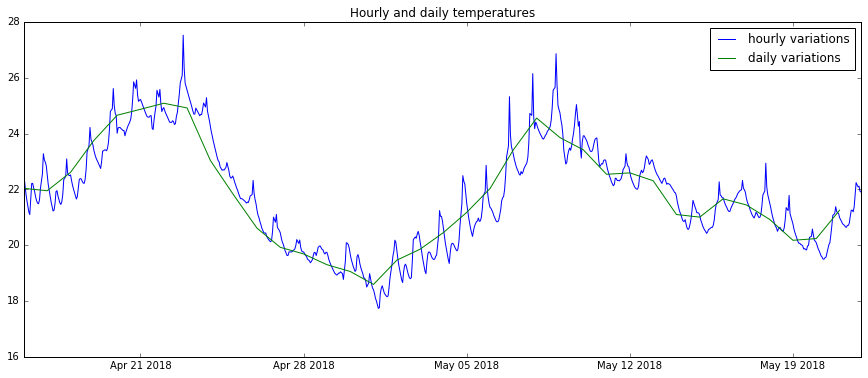

In [6]:
tsDay=tsTempCleaned.resample('D').mean() #resample the serie to keep only 1 temperature per day (the average of the day)
plt.title('Hourly and daily temperatures')
plt.plot(tsTempCleaned, color='blue', label='hourly variations')
plt.plot(tsDay, color='green', label='daily variations')
plt.legend(loc='best')

<H3>Get outside temperatures</H3>
If we assume that we know the outside temperature, the home temperature is not stationary as its mean and variance is correlated with the outside

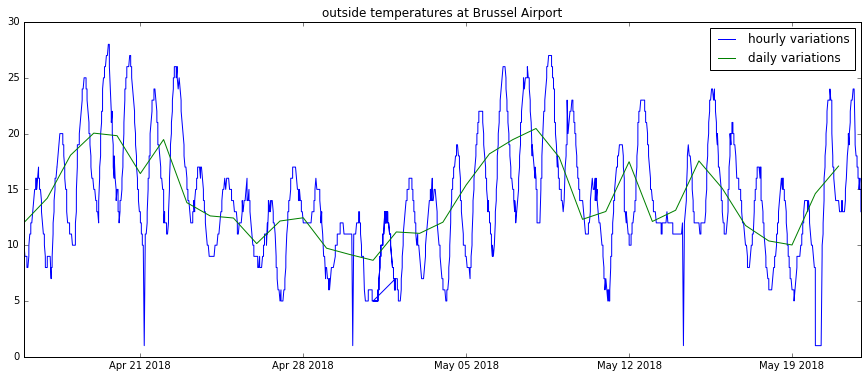

In [7]:
#load and parse the meteo data from Brussels airport (ICAO=EBBR)
file = open("metar.dat")
lines = file.readlines()
timeStamps=[]
temperatures=[]
for aline in lines:
    theTime=aline[:12]
    if not "20" in theTime:
        continue
    m = re.search('[0-9]+/', aline)
    if not m:
        continue
    timeStamps.append(pd.datetime.strptime(theTime, '%Y%m%d%H%M%S'))
    temperatures.append(int(m.group(0)[:-1]))
temperatures=pd.Series(temperatures, timeStamps)['2018-04-16':'2018-05-22 00:00']
plt.title('outside temperatures at Brussel Airport')
plt.plot(temperatures,color='blue', label='hourly variations')
tsOutDay=temperatures.resample('D').mean()
plt.plot(tsOutDay,color='green', label='daily variations')
plt.legend(loc='best')

<H3>Find a temperature model</H3>

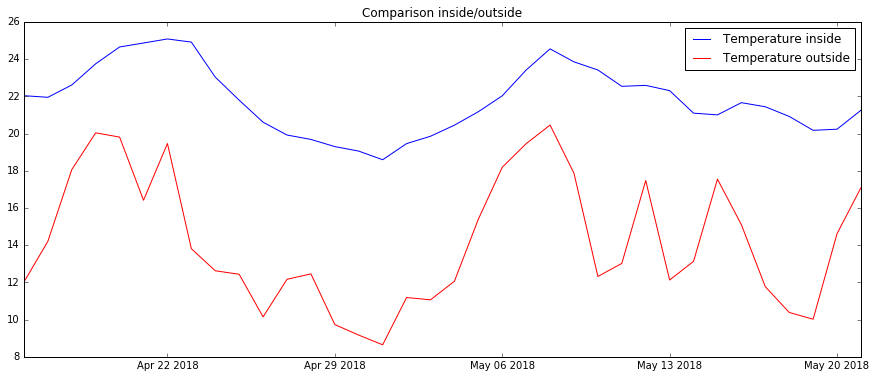

In [8]:
plt.title('Comparison inside/outside')
plt.plot(tsDay, color='blue',label='Temperature inside')
plt.plot(tsOutDay, color='red', label='Temperature outside')
plt.legend(loc='best')

Inside temperature obviously related with the outside one
<B>simple model:</B> time variation of inside temperature should be linearly correlated with the difference Tout - Tin

Slope:  0.192691099517
Intercept: 1.46242202115


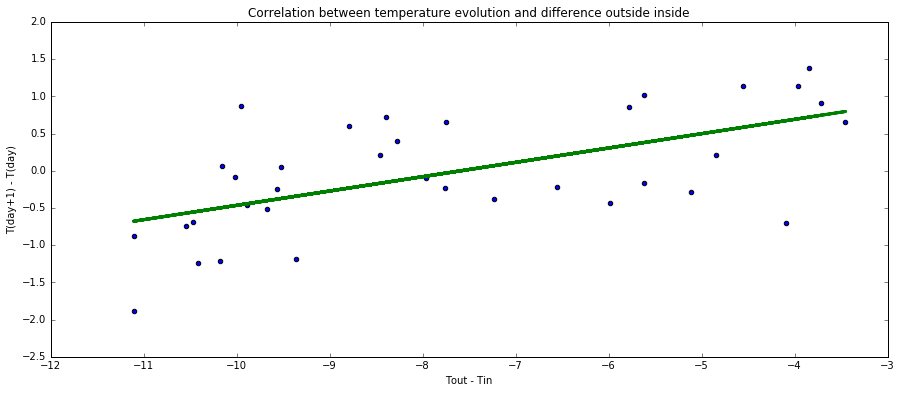

In [9]:
tsDiff=tsOutDay-tsDay
tsTimeDiff=tsDay.shift(periods=-1)-tsDay

#fit tsTimeDiff versus tsDiff using a lineare regression 
regr = linear_model.LinearRegression()
listDiff=[[aValue] for aValue in list(tsDiff[:-1])]
regr.fit(listDiff,list(tsTimeDiff[:-1]))
#get prediction to draw it on the plot
timeDiff=regr.predict(listDiff)

plt.title('Correlation between temperature evolution and difference outside inside')
plt.scatter(tsDiff[:-1],tsTimeDiff[:-1])
plt.plot(tsDiff[:-1], timeDiff, color='green', linewidth=3)
plt.xlabel('Tout - Tin')
plt.ylabel('T(day+1) - T(day)')
print('Slope: ', regr.coef_[0])
print('Intercept:',regr.intercept_)

In [10]:
predictionsNextDay=[]
predictionsNextDay.append(tsDay[0])
predictionAll=[]
predictionAll.append(tsDay[0])


for (tempOut, tempIn) in zip(tsOutDay[1:],tsDay[1:]):#zip(tsOutDay.shift(periods=-1),tsDay):
    predictionsNextDay.append(tempIn+0.1927*(tempOut-tempIn)+1.462)
    predictionAll.append(predictionAll[-1:][0]+0.1927*(tempOut-predictionAll[-1:][0])+1.462)

tsPredictionNextDay=pd.Series(predictionsNextDay, tsOutDay.index)
tsPredictionAll=pd.Series(predictionAll, tsOutDay.index)

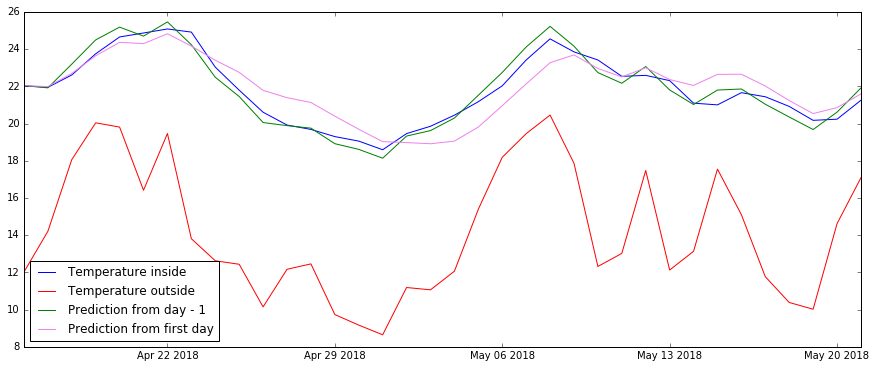

In [11]:
plt.plot(tsDay, color='blue',label='Temperature inside')
plt.plot(tsOutDay, color='red', label='Temperature outside')
plt.plot(tsPredictionNextDay, color='green', label='Prediction from day - 1 ')
plt.plot(tsPredictionAll, color='violet', label='Prediction from first day')
plt.legend(loc='best')

error on prediction from day -1 = 0.469092219209
error on prediction from first day = 0.826930291818


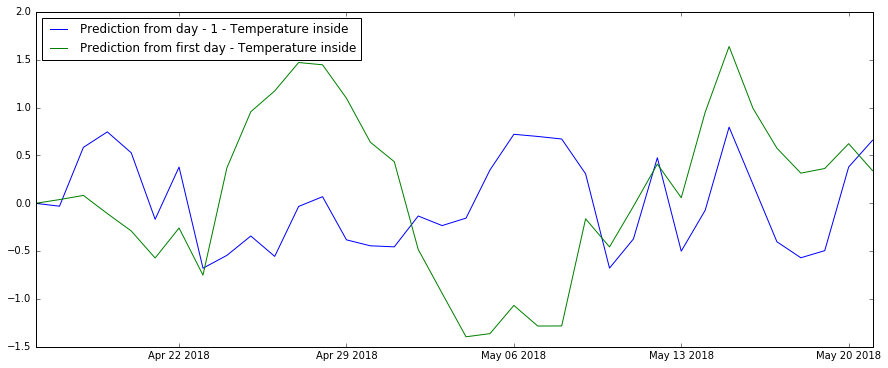

In [12]:
plt.plot(tsPredictionNextDay-tsDay, color='blue',label='Prediction from day - 1 - Temperature inside')
plt.plot(tsPredictionAll-tsDay, color='green', label='Prediction from first day - Temperature inside')
plt.legend(loc='best')
print("error on prediction from day -1 =",np.sqrt(np.var(tsPredictionNextDay-tsDay)))
print("error on prediction from first day =",np.sqrt(np.var(tsPredictionAll-tsDay)))

Standard deviation on prediction from day - 1 ~ 0.5°C <BR>
Standard deviation on prediction from first day  ~ 0.8°C

<H3>Conclusion on day-by-day average temperature modeling:</H3>

Average temperature for the next day can be predicted at the level of the 0.5°C if the outside temperature is knows. For a forecast of the outside temperature is available, then a longer term prediction can be done

<H2>Model for hourly variations</H2><A ID="dalyVariations"></A>

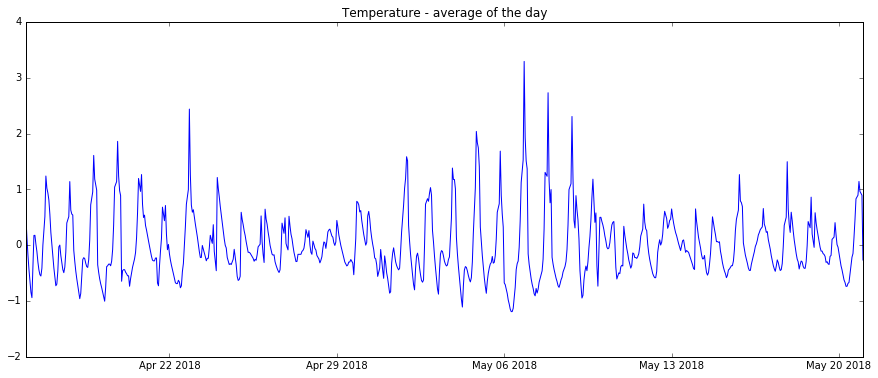

In [13]:
#soustract the average day variation from the temperature
tsDayPerHour = tsDay.resample('1H').ffill()
tsDailyVar=(tsTempCleaned-tsDayPerHour)
tsDailyVar.dropna(inplace=True)
plt.title('Temperature - average of the day')
plt.plot(tsDailyVar)

The variations of temperature within a day depends of numerous parameters that can be considered as random as a first approximation (heating system on/off, sunlight trough the windows, heat comming from human activity like cooking)

In [14]:
#Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(tsDailyVar, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.133881e+00
p-value                        8.276214e-08
#Lags Used                     2.100000e+01
Number of Observations Used    8.190000e+02
Critical Value (5%)           -2.865075e+00
Critical Value (10%)          -2.568653e+00
Critical Value (1%)           -3.438360e+00
dtype: float64


p-value of the non stationary hypothesis is ~ 8.3e-08 &#8594; the serie can be considered as a stationary serie 

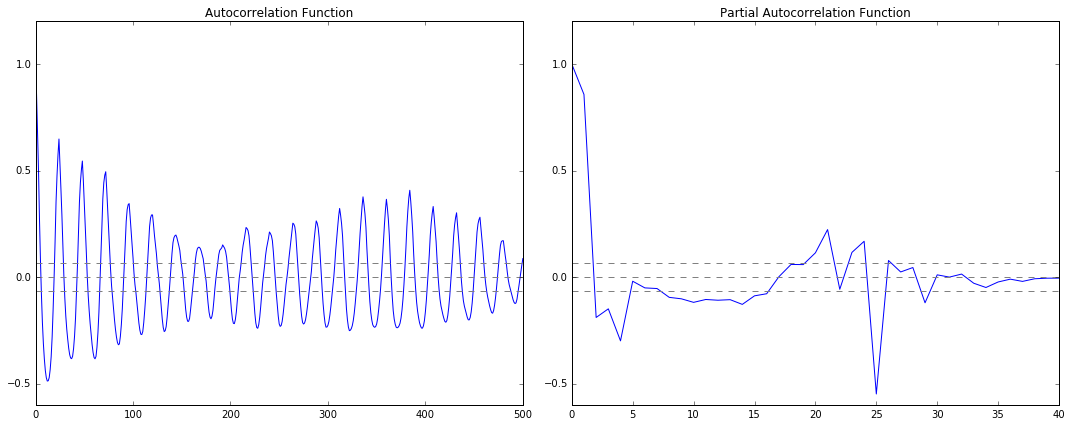

In [15]:
lag_acf = acf(tsDailyVar, nlags=500)

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsDailyVar)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsDailyVar)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
lag_pacf = pacf(tsDailyVar, nlags=40, method='ols')
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsDailyVar)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsDailyVar)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Still rather large autocorrelation on long time range because of the daily seasonality &#8594;
idea is to substract the seasonality by considering the difference between T(h) and T(h-24)

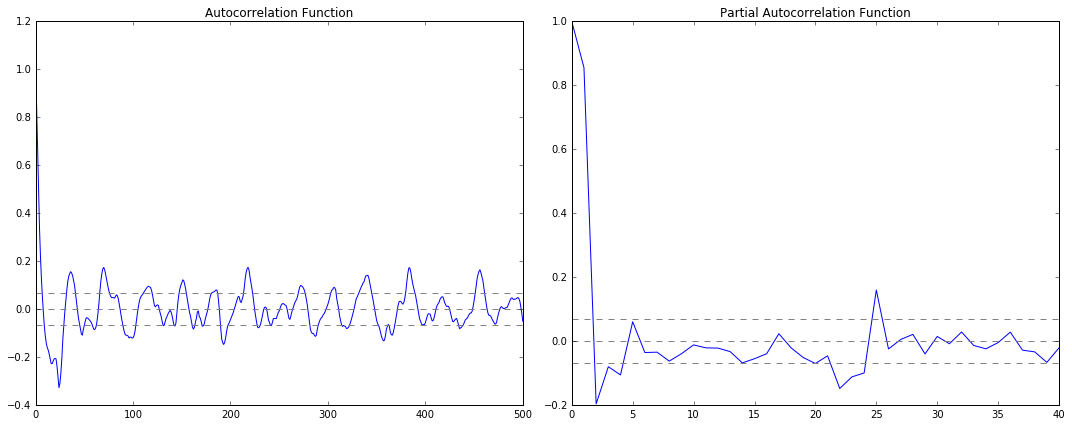

In [16]:
tsDailySeasonSubtracted = tsDailyVar-tsDailyVar.shift(24)
tsDailySeasonSubtracted.dropna(inplace=True)
plt.plot(tsDailySeasonSubtracted)

lag_acf = acf(tsDailySeasonSubtracted, nlags=500)

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsDailySeasonSubtracted)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsDailySeasonSubtracted)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
lag_pacf = pacf(tsDailySeasonSubtracted, nlags=40, method='ols')
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsDailySeasonSubtracted)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsDailySeasonSubtracted)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

much less long term correlation &#8594; this time serie should be possible to model with an arima model

<H3>Tunning of the ARIMA model</H3>

First tune the model by scanning the parameters

In [17]:
#scan parameter of the very simple ARIMA model ()
p = range(0,6)
r = range(0,2)
q =  range(0,2)
prq = list(itertools.product(p, r, q))

for param in prq:
    try:
        #print(param)
        model = ARIMA(tsDailySeasonSubtracted, order=(param[0], param[1], param[2]))
        results_AR = model.fit()
        print('ARIMA{} - AIC:{}'.format(param, results_AR.aic))
    except:
        print("ARIMA fit did not converge for ",param)
        continue

ARIMA(0, 0, 0) - AIC:1064.0054629611698
ARIMA(0, 0, 1) - AIC:411.0278434737718
ARIMA(0, 1, 0) - AIC:51.068898937968356
ARIMA(0, 1, 1) - AIC:43.09122540589078
ARIMA(1, 0, 0) - AIC:-7.816854088083346
ARIMA(1, 0, 1) - AIC:-32.674148723042435
ARIMA(1, 1, 0) - AIC:43.49542281861795
ARIMA(1, 1, 1) - AIC:42.577570928193836
ARIMA(2, 0, 0) - AIC:-37.40361042743825
ARIMA(2, 0, 1) - AIC:-45.510440073456266
ARIMA(2, 1, 0) - AIC:44.97595371464786
ARIMA(2, 1, 1) - AIC:-31.150067538720577
ARIMA(3, 0, 0) - AIC:-40.61465649339607
ARIMA(3, 0, 1) - AIC:-80.0226330704536
ARIMA(3, 1, 0) - AIC:46.9248072405785
ARIMA(3, 1, 1) - AIC:-34.19721215639629
ARIMA(4, 0, 0) - AIC:-47.68721841444949
ARIMA(4, 0, 1) - AIC:-49.041237262491904
ARIMA(4, 1, 0) - AIC:26.49166132578557
ARIMA(4, 1, 1) - AIC:-41.07435423461993
ARIMA(5, 0, 0) - AIC:-48.55042880913152
ARIMA(5, 0, 1) - AIC:-47.16047112760816
ARIMA(5, 1, 0) - AIC:25.721147522495812
ARIMA(5, 1, 1) - AIC:-41.89902577763178


ARIMA(p,r,q) model is fitting the best the data for p=3, r=0 and q=1

<H3>Check the predictive power of the model </H3>
<U>Idea is the following:</U><BR>
Train the model on the N past days and check how much it can predict the futur temperature

In [18]:
def getARIMApredictionFromPreviousDaysToNextDay(tsDailyVar, pastDaysUsed, timePredictionPeriod, sizeToThePredictionPeriod, p, r, q):
    #first remove the seasonality
    tsDailySeasonSubtracted = tsDailyVar-tsDailyVar.shift(24)
    tsDailySeasonSubtracted.dropna(inplace=True)


    firstDay = tsDailySeasonSubtracted.index[0]
    lastDay = tsDailySeasonSubtracted.index[-1]
    startingPredDay = firstDay+pd.Timedelta(days=pastDaysUsed) #prediction will start the first day after the N training days
    
    #initialize the series that will get the predictions
    allTheForcastedPrediction=tsDailySeasonSubtracted[startingPredDay:startingPredDay]
    allTheForcastedPredictionLow=tsDailySeasonSubtracted[startingPredDay:startingPredDay]
    allTheForcastedPredictionHigh=tsDailySeasonSubtracted[startingPredDay:startingPredDay]

    #now loop on the time stamp to get the prediction
    currentTimeStamp = startingPredDay
    while (currentTimeStamp+pd.Timedelta(hours=timePredictionPeriod)<startingPredDay+pd.Timedelta(days=sizeToThePredictionPeriod)):
        #fitting an ARIMA 
        durationPrev = currentTimeStamp-startingPredDay
        if (durationPrev.seconds%86400==0):#printout every day
            print("predicting for day ",currentTimeStamp)
        try:
            model = ARIMA(tsDailySeasonSubtracted[currentTimeStamp-pd.Timedelta(days=pastDaysUsed):currentTimeStamp], order=(p,r,q))
            results_AR = model.fit()
            forecast = results_AR.predict(start=currentTimeStamp+pd.Timedelta(hours=1), end=currentTimeStamp+pd.Timedelta(hours=timePredictionPeriod), dynamic=True)
            _, std, confInt = results_AR.forecast(steps=timePredictionPeriod)
            forecastLow = pd.Series(confInt[:,0], forecast.index)
            forecastHigh = pd.Series(confInt[:,1], forecast.index)
            
            allTheForcastedPrediction=pd.concat([allTheForcastedPrediction, forecast])
            allTheForcastedPredictionLow=pd.concat([allTheForcastedPredictionLow, forecastLow])
            allTheForcastedPredictionHigh=pd.concat([allTheForcastedPredictionHigh, forecastHigh])
            

        except:
            print("fit not converged for",currentTimeStamp)
            #if fit does not converge, the value is taken at 0 
            timeStamps=[currentTimeStamp+pd.Timedelta(hours=i) for i in range(1,1+timePredictionPeriod)]
            zeroList=[tsDailySeasonSubtracted[i] for i in timeStamps]
            forecast=pd.Series(zeroList, timeStamps) 
            allTheForcastedPrediction=pd.concat([allTheForcastedPrediction, forecast])
            allTheForcastedPredictionLow=pd.concat([allTheForcastedPredictionLow, forecast])
            allTheForcastedPredictionHigh=pd.concat([allTheForcastedPredictionHigh, forecast])


        currentTimeStamp += pd.Timedelta(hours=timePredictionPeriod)

        allForcastPlusDailyVar = allTheForcastedPrediction+tsDailyVar.shift(24)
        allForcastPlusDailyVar.dropna(inplace=True)

        allForcastPlusDailyVarLow = allTheForcastedPredictionLow+tsDailyVar.shift(24)
        allForcastPlusDailyVarLow.dropna(inplace=True)
        
        allForcastPlusDailyVarHigh = allTheForcastedPredictionHigh+tsDailyVar.shift(24)
        allForcastPlusDailyVarHigh.dropna(inplace=True)


    return (allForcastPlusDailyVar, allForcastPlusDailyVarLow, allForcastPlusDailyVarHigh)

predicting for day  2018-04-20 00:00:00
predicting for day  2018-04-21 00:00:00
predicting for day  2018-04-22 00:00:00
predicting for day  2018-04-23 00:00:00
fit not converged for 2018-04-23 19:00:00
predicting for day  2018-04-24 00:00:00
predicting for day  2018-04-25 00:00:00
predicting for day  2018-04-26 00:00:00
predicting for day  2018-04-27 00:00:00
predicting for day  2018-04-28 00:00:00
fit not converged for 2018-04-28 23:00:00
predicting for day  2018-04-29 00:00:00
fit not converged for 2018-04-29 02:00:00
fit not converged for 2018-04-29 10:00:00


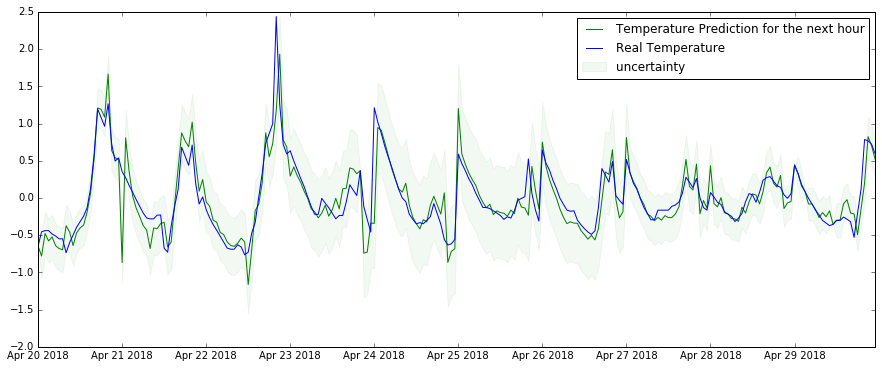

In [19]:
#get prediction the temperature in the next hour during 10 days (using the 3 last days for training)
allPredictions, allPredictionsLow, allPredictionsHigh = getARIMApredictionFromPreviousDaysToNextDay(tsDailyVar, 3, 1,10, 3,0,1)

plt.plot(allPredictions, color='green',label='Temperature Prediction for the next hour')
plt.fill_between(allPredictionsLow.index, allPredictionsLow,allPredictionsHigh,color='green',alpha=0.05, label='uncertainty')
plt.plot(tsDailyVar[allPredictions.index[0]:allPredictions.index[-1]], color='blue',label='Real Temperature')
plt.legend(loc='best')


0.011328370806902388
0.23895118444


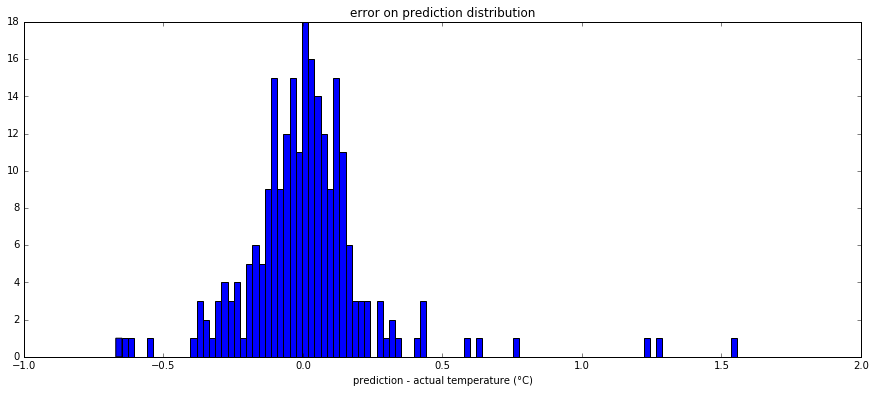

In [20]:
#look at the distribution of the error on prediction
histo,bins,_=plt.hist(tsDailyVar[allPredictions.index[0]:allPredictions.index[-1]]-allPredictions, bins=100)
plt.xlabel('prediction - actual temperature (°C)')
plt.title('error on prediction distribution')

print(np.mean(tsDailyVar[allPredictions.index[0]:allPredictions.index[-1]]-allPredictions))
print(np.sqrt(np.var(tsDailyVar[allPredictions.index[0]:allPredictions.index[-1]]-allPredictions)))

Very small bias (~0.01°C) and relatively small standard error of ~0.24°C<BR>
<B>What does bring the ARIMA model to the prediction acuracy ?</B><BR>
To evaluate it, looking at standard deviation when using the temperature of the previous day as a prediction 

In [21]:
tsDailySeasonSubtracted = tsDailyVar - tsDailyVar.shift(24)
print(np.sqrt(np.var(tsDailySeasonSubtracted)))

0.462911040911


Error from using the previous day for a prediction ~0.5°C &#8594; the model permits to reduce the error by ~50% compared to this prediction

<H3>Optimisation of the training period</H3>
Right now 3 days are used to train the model, is a tuning possible ?  

In [22]:
nbOfDayUsed=[]
bias=[]
error=[]
for aNbOfDay in range(1, 6):
    print("trying ",aNbOfDay," days")
    nbOfDayUsed.append(aNbOfDay)
    allPredictions, allPredictionsLow, allPredictionsHigh = getARIMApredictionFromPreviousDaysToNextDay(tsDailyVar, aNbOfDay, 1,10, 3,0,1);
    bias.append(np.mean(tsDailyVar[allPredictions.index[0]:allPredictions.index[-1]]-allPredictions))
    error.append(np.sqrt(np.var(tsDailyVar[allPredictions.index[0]:allPredictions.index[-1]]-allPredictions)))

trying  1  days
predicting for day  2018-04-18 00:00:00
fit not converged for 2018-04-18 19:00:00
fit not converged for 2018-04-18 20:00:00
fit not converged for 2018-04-18 21:00:00
fit not converged for 2018-04-18 22:00:00
predicting for day  2018-04-19 00:00:00
fit not converged for 2018-04-19 01:00:00
fit not converged for 2018-04-19 02:00:00
predicting for day  2018-04-20 00:00:00
fit not converged for 2018-04-20 14:00:00
fit not converged for 2018-04-20 21:00:00
fit not converged for 2018-04-20 22:00:00
predicting for day  2018-04-21 00:00:00
fit not converged for 2018-04-21 00:00:00
fit not converged for 2018-04-21 01:00:00
fit not converged for 2018-04-21 18:00:00
fit not converged for 2018-04-21 20:00:00
predicting for day  2018-04-22 00:00:00
fit not converged for 2018-04-22 05:00:00
fit not converged for 2018-04-22 06:00:00
fit not converged for 2018-04-22 15:00:00
fit not converged for 2018-04-22 16:00:00
fit not converged for 2018-04-22 19:00:00
fit not converged for 2018-0

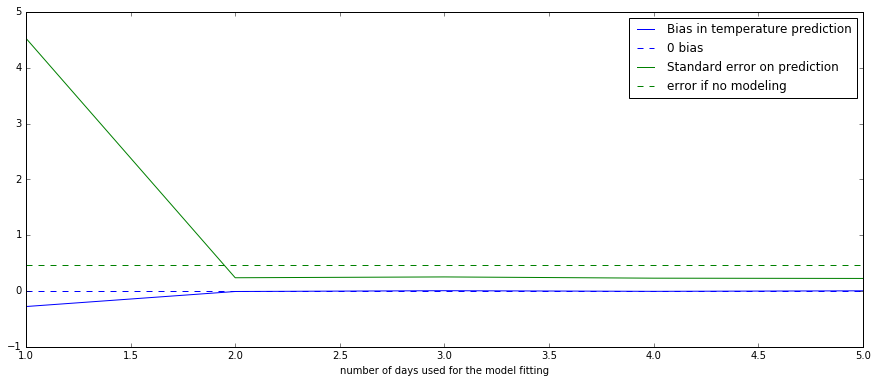

In [23]:
plt.plot(nbOfDayUsed,bias, color='blue',label='Bias in temperature prediction')
plt.axhline(y=0,linestyle='--',color='blue', label='0 bias')
plt.plot(nbOfDayUsed,error, color='green',label='Standard error on prediction')
plt.axhline(y=0.462911040911,linestyle='--',color='green', label='error if no modeling')
plt.xlabel('number of days used for the model fitting')
plt.legend(loc='best')

From 2 days the model has a good prediction power, the best value is obtained for 4 days

In [24]:
bias=[]
error=[]
constantBias=[]
constantError=[]
sizePrediction=[1,3,6,12,24]
for AsizePrediction in sizePrediction:
    print("prediction for ",AsizePrediction," hours")
    allPredictions, allPredictionsLow, allPredictionsHigh = getARIMApredictionFromPreviousDaysToNextDay(tsDailyVar, 4, AsizePrediction,10, 3,0,1);
    bias.append(np.mean(tsDailyVar[allPredictions.index[0]:allPredictions.index[-1]]-allPredictions))
    error.append(np.sqrt(np.var(tsDailyVar[allPredictions.index[0]:allPredictions.index[-1]]-allPredictions)))
    tsDailySeasonSubtracted = tsDailyVar - tsDailyVar.shift(AsizePrediction)
    constantBias.append(np.mean(tsDailySeasonSubtracted))
    constantError.append(np.sqrt(np.var(tsDailySeasonSubtracted)))

prediction for  1  hours
predicting for day  2018-04-21 00:00:00
predicting for day  2018-04-22 00:00:00
predicting for day  2018-04-23 00:00:00
predicting for day  2018-04-24 00:00:00
fit not converged for 2018-04-24 06:00:00
predicting for day  2018-04-25 00:00:00
predicting for day  2018-04-26 00:00:00
predicting for day  2018-04-27 00:00:00
predicting for day  2018-04-28 00:00:00
predicting for day  2018-04-29 00:00:00
predicting for day  2018-04-30 00:00:00
prediction for  3  hours
predicting for day  2018-04-21 00:00:00
predicting for day  2018-04-22 00:00:00
predicting for day  2018-04-23 00:00:00
predicting for day  2018-04-24 00:00:00
fit not converged for 2018-04-24 06:00:00
predicting for day  2018-04-25 00:00:00
predicting for day  2018-04-26 00:00:00
predicting for day  2018-04-27 00:00:00
predicting for day  2018-04-28 00:00:00
predicting for day  2018-04-29 00:00:00
predicting for day  2018-04-30 00:00:00
prediction for  6  hours
predicting for day  2018-04-21 00:00:00
p

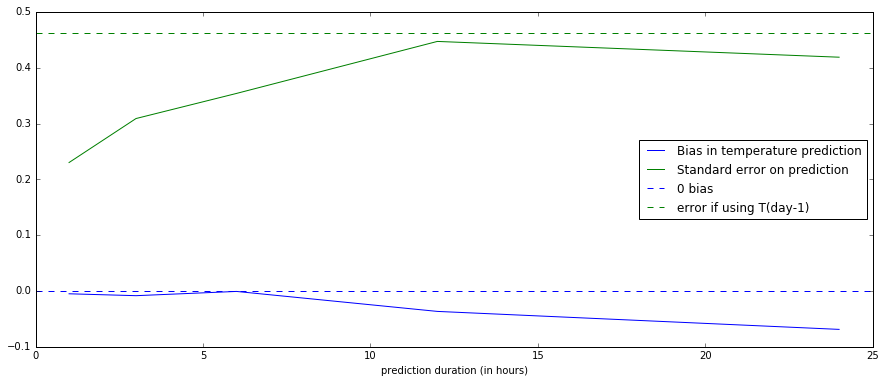

In [25]:
plt.plot(sizePrediction,bias, color='blue',label='Bias in temperature prediction')
plt.plot(sizePrediction,error, color='green',label='Standard error on prediction')
plt.axhline(y=0,linestyle='--',color='blue', label='0 bias')
plt.axhline(y=0.462911040911,linestyle='--',color='green', label='error if using T(day-1)')
plt.xlabel('prediction duration (in hours)')
plt.legend(loc='best')

<B>short term prediction gives improvement up to 6 hours</B> From 12 hours, bias starts to increase and error improvement from the model is small. 

<H2>Full temperature model</H2><A ID="fullModel">

As seen in the previous section, short term prediction gives an improvement up to 6 hours.
It means that using the prediction of the average temperature of the next day is an overkill. 
The idea is then to use the same strategy as for the modeling of the temperature variations within a day: Prediction with an ARIMA model of the difference between T(day-1) and T

predicting for day  2018-04-21 00:00:00
fit not converged for 2018-04-21 05:00:00
predicting for day  2018-04-22 00:00:00
predicting for day  2018-04-23 00:00:00
predicting for day  2018-04-24 00:00:00
fit not converged for 2018-04-24 00:00:00
predicting for day  2018-04-25 00:00:00
predicting for day  2018-04-26 00:00:00
predicting for day  2018-04-27 00:00:00
fit not converged for 2018-04-27 08:00:00
predicting for day  2018-04-28 00:00:00
fit not converged for 2018-04-28 19:00:00
predicting for day  2018-04-29 00:00:00
predicting for day  2018-04-30 00:00:00


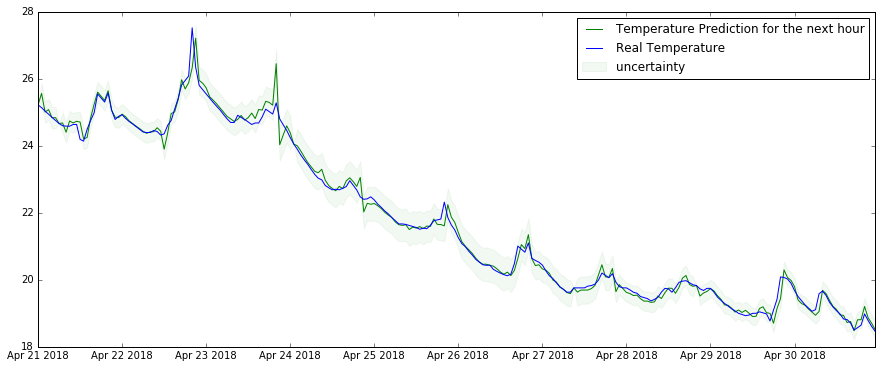

In [26]:
# same a before but use now the absolute temperature 
allPredictions, allPredictionsLow, allPredictionsHigh = getARIMApredictionFromPreviousDaysToNextDay(tsTempCleaned, 4, 1,10, 3,0,1)

plt.plot(allPredictions, color='green',label='Temperature Prediction for the next hour')
plt.fill_between(allPredictionsLow.index, allPredictionsLow,allPredictionsHigh,color='green',alpha=0.05, label='uncertainty')
plt.plot(tsTempCleaned[allPredictions.index[0]:allPredictions.index[-1]], color='blue',label='Real Temperature')
plt.legend(loc='best')

-0.015729686652984423
0.205190410433


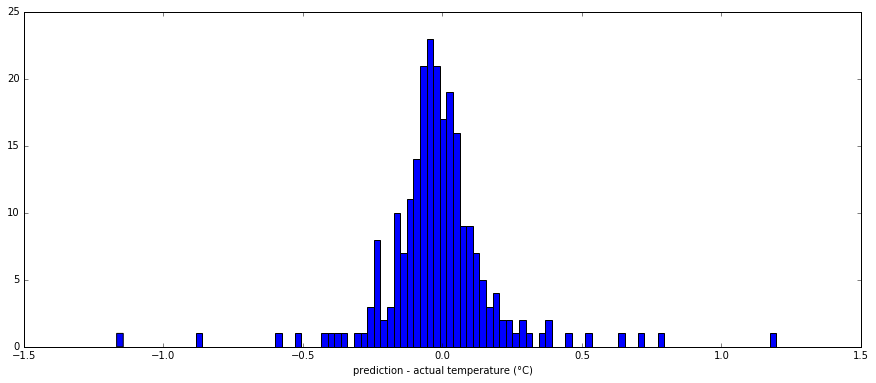

In [27]:
diff=tsTempCleaned[allPredictions.index[0]:allPredictions.index[-1]]-allPredictions
diff.dropna(inplace=True)

histo,bins,_=plt.hist(diff, bins=100)
plt.xlabel('prediction - actual temperature (°C)')

print(np.mean(tsTempCleaned[allPredictions.index[0]:allPredictions.index[-1]]-allPredictions))
print(np.sqrt(np.var(tsTempCleaned[allPredictions.index[0]:allPredictions.index[-1]]-allPredictions)))

In [28]:
bias=[]
error=[]
sizePrediction=[1,3,6,12,24]
for AsizePrediction in sizePrediction:
    print("prediction for ",AsizePrediction," hours")
    allPredictions, allPredictionsLow, allPredictionsHigh = getARIMApredictionFromPreviousDaysToNextDay(tsTempCleaned, 4, AsizePrediction,10, 3,0,1);
    bias.append(np.mean(tsTempCleaned[allPredictions.index[0]:allPredictions.index[-1]]-allPredictions))
    error.append(np.sqrt(np.var(tsTempCleaned[allPredictions.index[0]:allPredictions.index[-1]]-allPredictions)))


prediction for  1  hours
predicting for day  2018-04-21 00:00:00
fit not converged for 2018-04-21 05:00:00
predicting for day  2018-04-22 00:00:00
predicting for day  2018-04-23 00:00:00
predicting for day  2018-04-24 00:00:00
fit not converged for 2018-04-24 00:00:00
predicting for day  2018-04-25 00:00:00
predicting for day  2018-04-26 00:00:00
predicting for day  2018-04-27 00:00:00
fit not converged for 2018-04-27 08:00:00
predicting for day  2018-04-28 00:00:00
fit not converged for 2018-04-28 19:00:00
predicting for day  2018-04-29 00:00:00
predicting for day  2018-04-30 00:00:00
prediction for  3  hours
predicting for day  2018-04-21 00:00:00
predicting for day  2018-04-22 00:00:00
predicting for day  2018-04-23 00:00:00
predicting for day  2018-04-24 00:00:00
fit not converged for 2018-04-24 00:00:00
predicting for day  2018-04-25 00:00:00
predicting for day  2018-04-26 00:00:00
predicting for day  2018-04-27 00:00:00
predicting for day  2018-04-28 00:00:00
predicting for day  

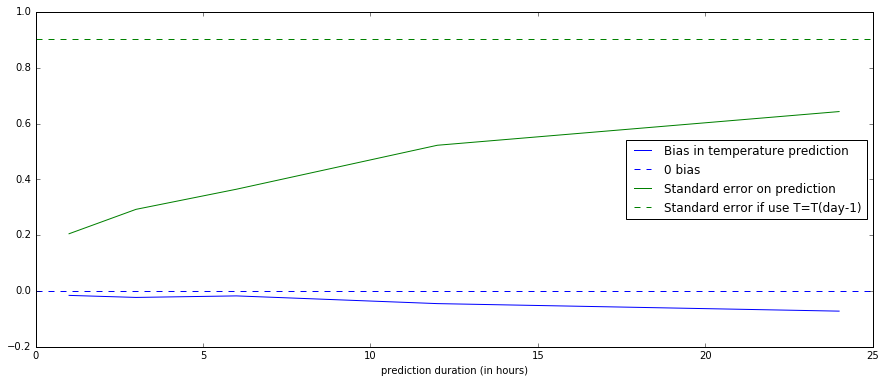

In [29]:
plt.plot(sizePrediction,bias, color='blue',label='Bias in temperature prediction')
plt.axhline(y=0,linestyle='--',color='blue', label='0 bias')
plt.plot(sizePrediction,error, color='green',label='Standard error on prediction')
plt.axhline(y=0.903823511817,linestyle='--',color='green', label='Standard error if use T=T(day-1)')
plt.xlabel('prediction duration (in hours)')
plt.legend(loc='best')

In [30]:
tsDailySeasonSubtracted = tsTempCleaned - tsTempCleaned.shift(24)
print("std error when using T(day-1) as a prediction:",np.sqrt(np.var(tsDailySeasonSubtracted)))
tsDailySeasonSubtracted = tsTempCleaned - tsTempCleaned.shift(1)
print("std error when using T(H-1) as a prediction:",np.sqrt(np.var(tsDailySeasonSubtracted)))

std error when using T(day-1) as a prediction: 0.903823511817
std error when using T(H-1) as a prediction: 0.256359062943


The model permits an estimation of the temperature with an error going from 0.2°C for the next hour to 0.6°C for the next 24h. For the next 12 hours, the estimation is still better than ~0.5°C 

<H2>Summary:</H2><A ID="summary"></ID>

From a simple ARIMA model fitted on the 4 last days, the temperatures inside a room can be estimated with an error of the order of ~0.5°C in the next 24H <BR>
For this short term prediction, no weather forecast is needed but the prediction of the temperature could be of course improved by using additional data (weather forecast, sun or cloudy outisde, status of the heating system, human activity in the room...)
<BR>

<H3>Business opportunity:</H3>
This prediction could be useful for providing <B><font color="red">simple home automation solution</font></B>. For example, the forecast of the temperature can be used to predict how much to water the plants, could be used to optimise the heating system by anticipating the futur temperature variations (no need to switch on the heating if the temperature will naturally raise...) <BR>
The big advantage of this system is that it is <B>very simple and low cost</B> (only a temperature sensor is needed)